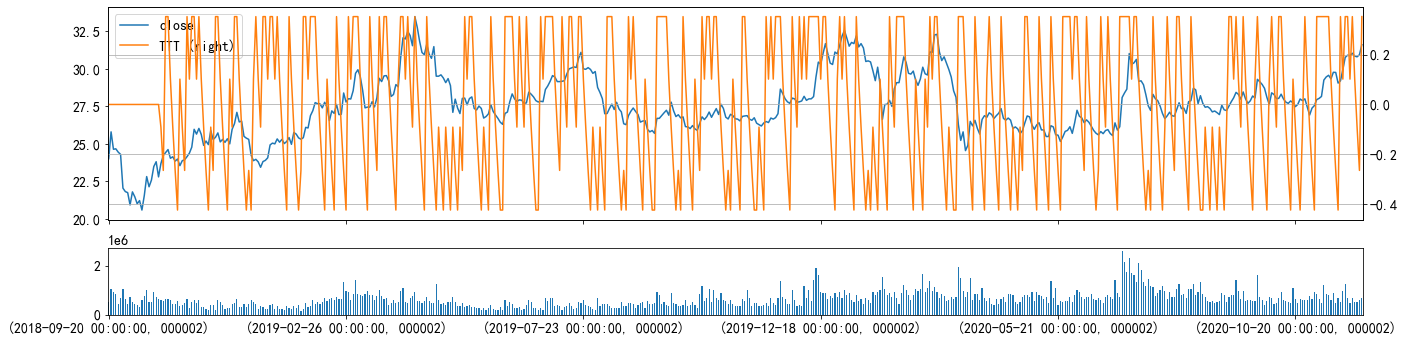

In [330]:
# %%writefile Ind_ADX_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

# import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
import base.JuUnits as ju
import toys

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class Alpha_Auto(Ind_Model_Base.Ind_Model):
    """ 顺势指标
        
    """
    optimum_param={'valid':False, 'main':'Alpha_Auto', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'Alpha_Auto', frequence)
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':14}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
#         def feature(item_df):
#             direct = np.sign(item_df['UP'] - item_df['DOWN'])
            
#             continuity = af.timeline_event_continuity(direct.fillna(0))
#             continuity[continuity<0] = continuity[continuity<0]*5
#             return -1 * np.abs(continuity)
        
# #             return -1 * np.abs(af.timeline_event_continuity(direct.fillna(0)))
            
# #             return af.timeline_event_continuity(direct.fillna(0))

#         event_continuity = self.excute_for_multicode(self.ind_df,
#                                          lambda x: pd.DataFrame(feature(x),
#                                          index=x.index,
#                                          columns=['feature_HT_CONTINUITY_NEG_ABS']))
#         # NEG_ABS时防止0干扰
#         event_continuity[event_continuity==0] = np.nan
#         self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return None #event_continuity
        
    def kernel(self,dataframe, timeperiod):
        if len(dataframe)<=timeperiod:
            return None
        
        ttt = toys.alpha1(dataframe.open, dataframe.close-dataframe.close.shift(1))
        # ttt = toys.alpha4(dataframe.low)
        ttt.name="TTT"
        

#         try:
#             ma = talib.MA(cci, timeperiod)
#         except:
#             print(dataframe)
#         ma.name = 'CCIMA'
        
#         df = pd.concat([integer], axis=1)
        df = pd.DataFrame(ttt)
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        

import tools.Sample_Tools as smpl
data = smpl.get_data(['000002'],end='2020-11-29',gap=528).data

ttt =TTT(data)
ttt.fit()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(1620/72,620/72))
ax1= fig.add_subplot(2,1,1)
# pd.concat([data.close,ht.ind_df['zhouqi']*5,ht.ind_df['jieduan']],axis=1).plot(secondary_y=['zhouqi','jieduan'],ax=ax1)
# pd.concat([data.close,ht.ind_df['inphase'],ht.ind_df['quadrature']],axis=1).plot(secondary_y=['inphase','quadrature'],ax=ax1)
pd.concat([data.close,ttt.ind_df['TTT']],axis=1).plot(secondary_y=['TTT'],ax=ax1)
plt.grid()
ax2= fig.add_subplot(6,1,4,sharex=ax1)
data.volume.plot(kind='bar',ax=ax2)
ax2.tick_params(labelbottom=True)  #  解决share后标签不可见的问题。
ax2.xaxis.set_major_locator(ticker.MaxNLocator(6))

Wall time: 1.18 s


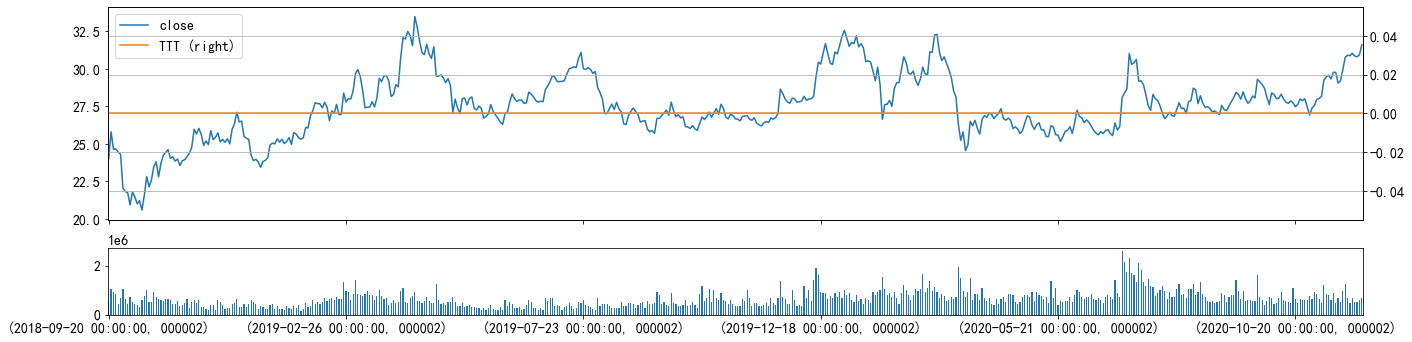

In [190]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import talib
data = smpl.get_data(['000002'],end='2020-11-29',gap=528).data

ttt =TTT(data)
ttt.fit()


fig = plt.figure(figsize=(1620/72,620/72))
ax1= fig.add_subplot(2,1,1)
# pd.concat([data.close,ht.ind_df['zhouqi']*5,ht.ind_df['jieduan']],axis=1).plot(secondary_y=['zhouqi','jieduan'],ax=ax1)
# pd.concat([data.close,ht.ind_df['inphase'],ht.ind_df['quadrature']],axis=1).plot(secondary_y=['inphase','quadrature'],ax=ax1)
pd.concat([data.close,ttt.ind_df['TTT']],axis=1).plot(secondary_y=['TTT'],ax=ax1)
plt.grid()
ax2= fig.add_subplot(6,1,4,sharex=ax1)
data.volume.plot(kind='bar',ax=ax2)
ax2.tick_params(labelbottom=True)  #  解决share后标签不可见的问题。
ax2.xaxis.set_major_locator(ticker.MaxNLocator(6))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-11-28


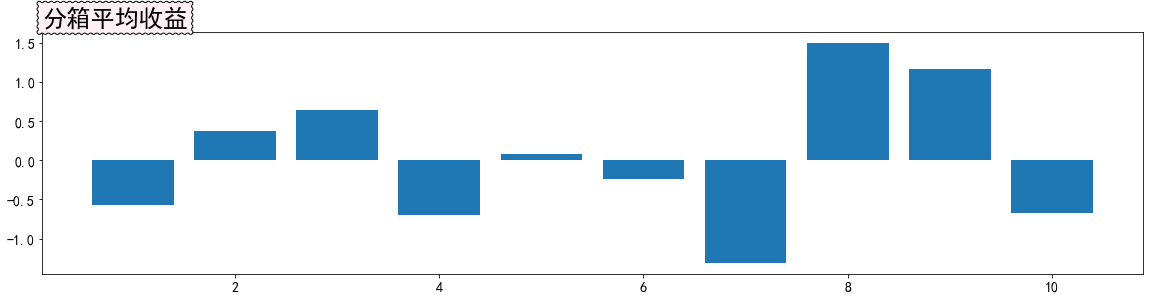

2020-11-28


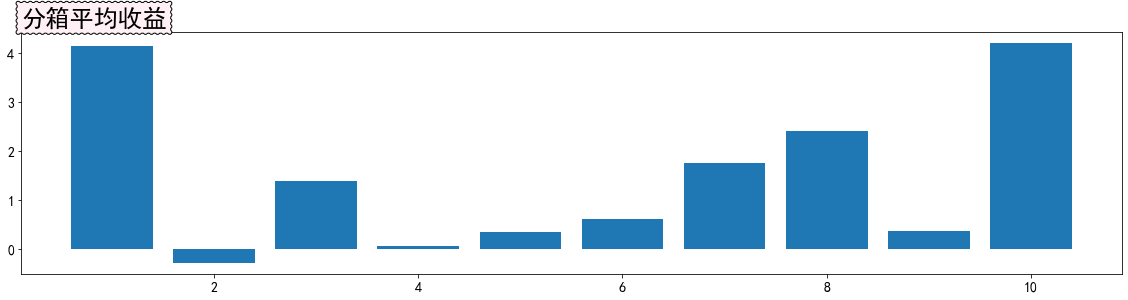

2019-11-28


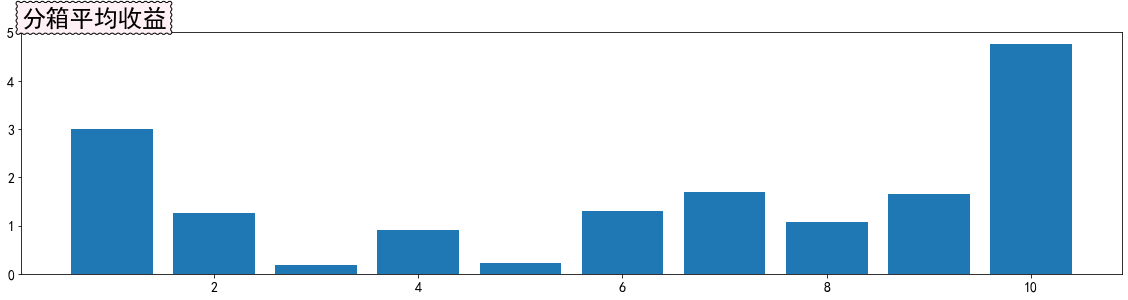

2018-11-28


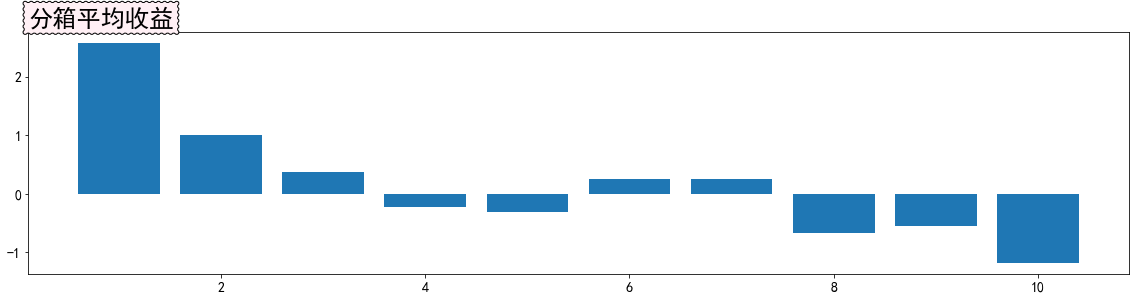

2017-11-28


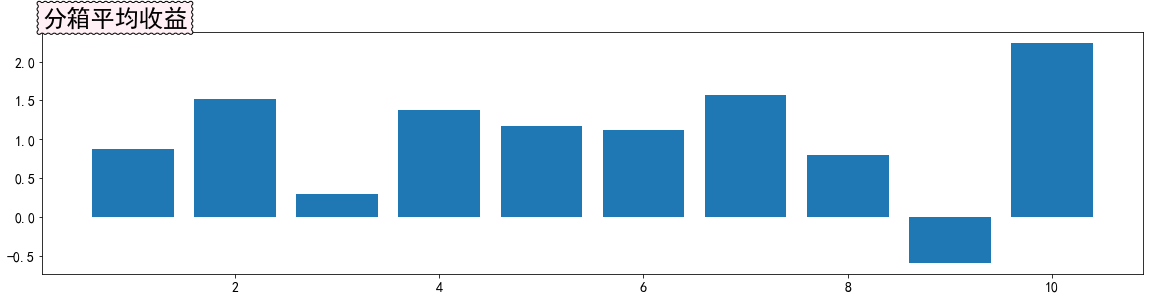

2016-11-28


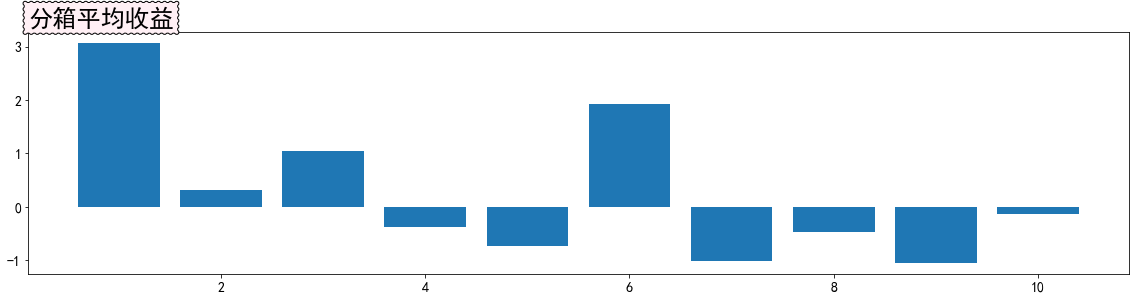

Wall time: 18.1 s


In [5]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2020-11-28']
for date in dates:
    print(date)
    test = FactorTest(TTT, sample='上证50', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='TTT')
    test.process()
    test.plot(only_binned=True)


2021-11-28


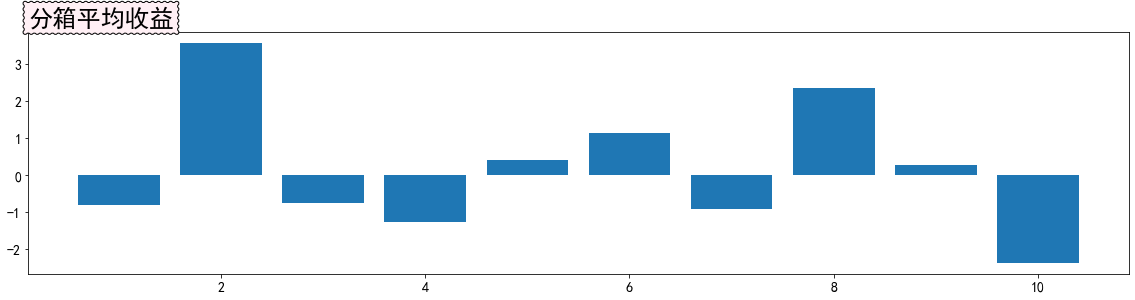

2020-11-28


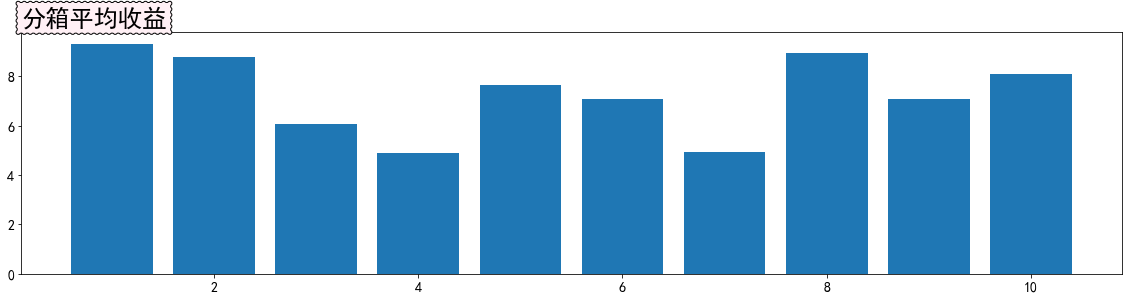

2019-11-28


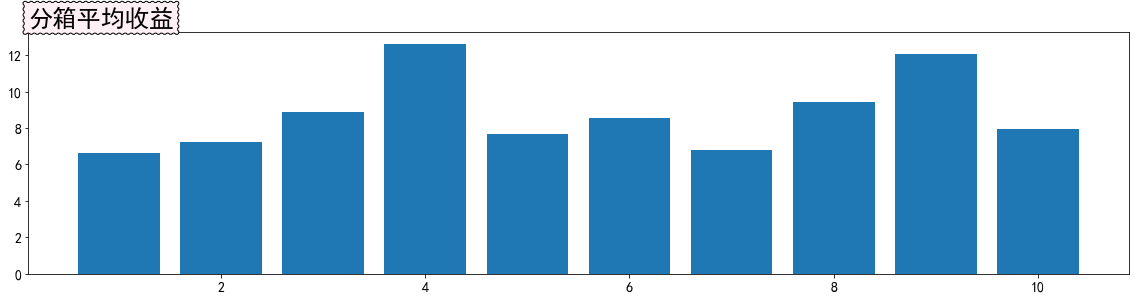

2018-11-28


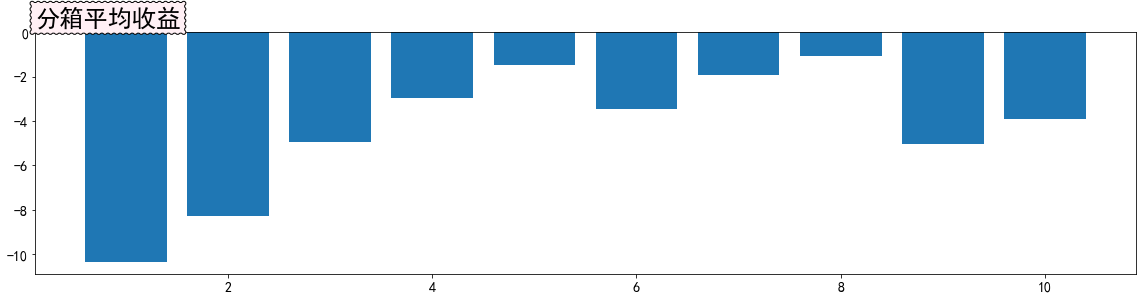

2017-11-28


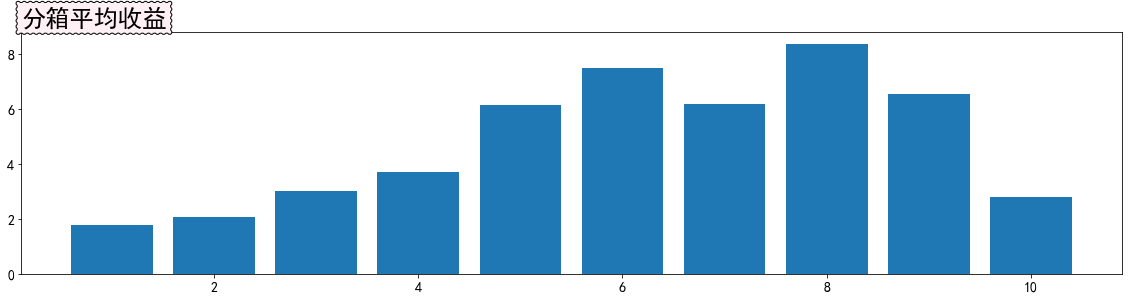

2016-11-28


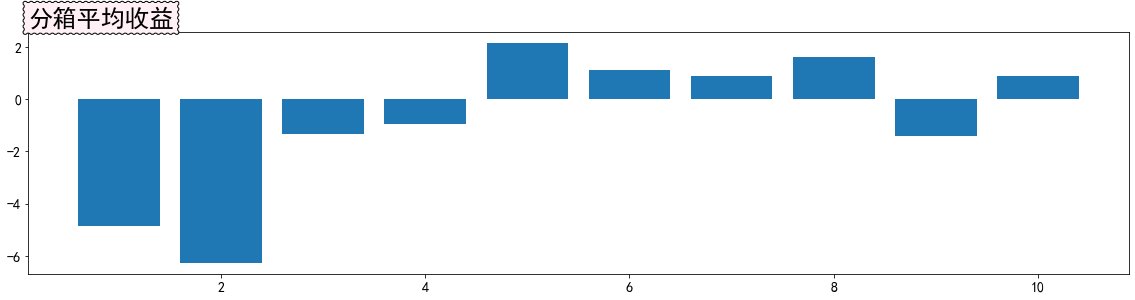

In [6]:
dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2020-11-28']
for date in dates:
    print(date)
    test = FactorTest(TTT, sample='沪深300', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='TTT')
    test.process()
    test.plot(only_binned=True)

In [62]:
from tools.Test_Tools import FactorTest

# dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
dates = ['2017-11-28']
for date in dates:
    print(date)
    test = FactorTest(TTT, sample='沪深300', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='TTT')
    test.process()
    x = test.get_ind_binned_ret_avg()
    # print(x)
print(x)
print(x.rank())
print(np.corrcoef(x,x.index))
print(np.corrcoef(x.rank(),x.index))



2017-11-28
group_label
1     9.826463
2     5.787377
3     5.325664
4     2.170630
5     1.028793
6     5.248035
7     3.333540
8     4.557912
9    -0.258488
10    3.248308
dtype: float64
group_label
1     10.0
2      9.0
3      8.0
4      3.0
5      2.0
6      7.0
7      5.0
8      6.0
9      1.0
10     4.0
dtype: float64
[[ 1.         -0.63318572]
 [-0.63318572  1.        ]]
[[ 1.         -0.66060606]
 [-0.66060606  1.        ]]


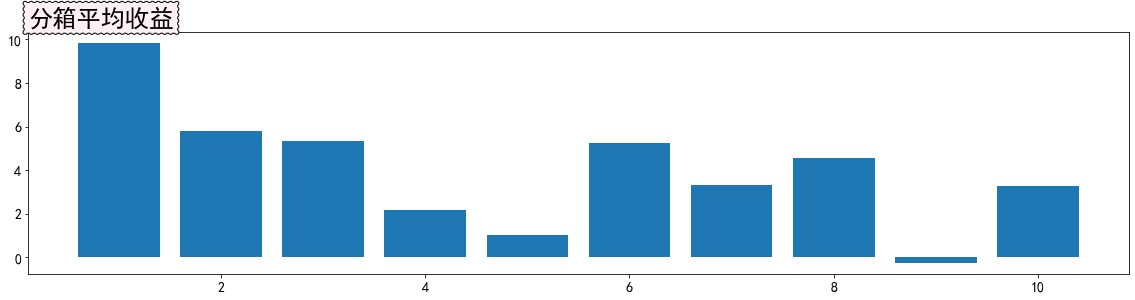

In [63]:
test.plot(only_binned=True)

In [3]:
getattr(toys, 'alpha4')(data.low)

date        code  
2018-09-20  000002    0.0
2018-09-21  000002    0.0
2018-09-25  000002    0.0
2018-09-26  000002    0.0
2018-09-27  000002    0.0
                     ... 
2020-11-23  000002   -9.0
2020-11-24  000002   -8.0
2020-11-25  000002   -7.5
2020-11-26  000002   -4.0
2020-11-27  000002   -9.0
Name: low, Length: 529, dtype: float64

In [10]:
# import inspect
for param in inspect.signature(getattr(toys, 'alpha1')).parameters.items():
    print(param[0])

mappingproxy({'close': <Parameter "close">, 'returns': <Parameter "returns">})

In [12]:
param_list = []
for i in range(1,101):
    for param in inspect.signature(getattr(toys, 'alpha'+str(i))).parameters.items():
        param_list.append(param[0])
        
set(param_list)

{'Open', 'cap', 'close', 'high', 'ind', 'low', 'returns', 'volume', 'vwap'}

-0.13127164973309527


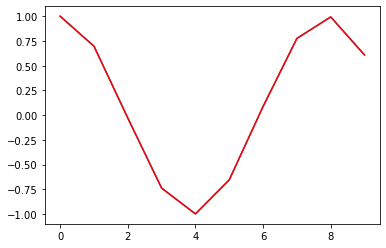

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

def f(x):
    return np.cos(x*0.8)
    # return (x-3.5)**2

x = np.array(range(10))
y = f(x)
y = y/np.abs(y).max()


print(np.corrcoef(x,-y)[0][1])
# np.polyval(f, x)

plt.plot(x, y)
plt.plot(x, y,c='r')

plt.show()


-0.24848484848484845 2 3
invalid


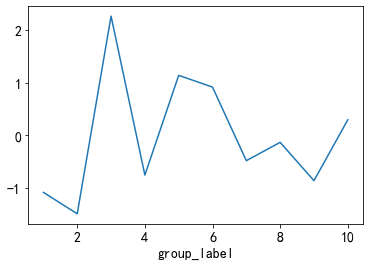

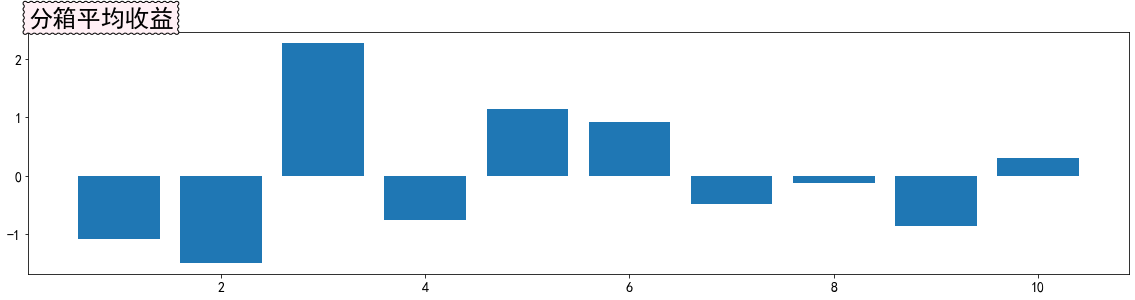

In [341]:
# from tools.Test_Tools import FactorTest

def check_quality(ind_binned_ret):
    x = ind_binned_ret
    # x = x/np.abs(x).max()+0.000001
    r_cor = np.corrcoef(x.rank(ascending=False),x.index)[0][1]
    print(r_cor,x.idxmin(),x.idxmax())
    
    if np.abs(r_cor)>0.5:
        if x.idxmax() in [1,2]:
            return 'valid_left'
        if x.idxmax() in [9,10]:
            return 'valid_right'
        return 'invalid'
    
    if np.abs(r_cor) < 0.16:
        if x.idxmax() in [5,6]:
            return 'sem_mid'
        if x.idxmax() in [1,10]:
            x[x.idxmax()]=0
            if x.idxmax() in [1,10]:
                return 'sem_bilateral'
        return 'invalid'
    
    return 'invalid'


test = FactorTest(TTT, sample='上证50', freq="d",end='2021-11-28', gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='TTT')
test.process()

# def f(x):
#     return -np.cos(x*0.9)
# x = np.array(range(10))+1

# s = pd.Series(f(x),index=x)
s=test.get_ind_binned_ret_avg()
print(check_quality(s))
s.plot()
test.plot(only_binned=True)
 

In [418]:
import tools.Sample_Tools as smpl

# %load_ext autoreload
# %autoreload 2
# %aimport tools.Sample_Tools

# import tools.Pretreat_Tools as pretreat
# from base.JuUnits import excute_for_multidates
data = smpl.get_sample_by_zs(name='上证50', end='2021-11-28', gap=50,  only_main=True)
ret_forward = smpl.get_current_return(data,'close')
# {'Open', 'cap', 'close', 'high', 'ind', 'low', 'returns', 'volume', 'vwap'}
data = pd.concat([data.data, ret_forward], axis=1)
data= smpl.add_marketvalue_industry(data)
data.rename(columns = {"open":"Open","ret":"returns",'totalCapital':'cap','industry':'ind'},inplace=True)
data
# res = excute_for_multidates(data, lambda x: toys.alpha1(x['close'], x['returns']),level=1)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', 999):
#     print(res)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', 999):
#     excute_for_multidates(data, lambda x: print(x) ,level=1)

Open    high     low   close     volume        amount  \
date       code                                                              
2021-09-10 600000    9.32    9.48    9.31    9.41   572507.0  5.379638e+08   
           600028    4.63    4.67    4.52    4.55  3531258.0  1.620610e+09   
           600030   26.81   27.98   26.81   27.27  2152491.0  5.887666e+09   
           600031   28.30   28.75   27.81   28.31  1463076.0  4.128626e+09   
           600036   52.00   54.52   51.75   54.12  1070978.0  5.766878e+09   
...                   ...     ...     ...     ...        ...           ...   
2021-11-26 601995   49.00   49.29   48.47   48.61   104169.0  5.085307e+08   
           603259  137.00  141.47  137.00  139.66   312921.0  4.374394e+09   
           603288  114.68  116.00  113.30  114.66    42918.0  4.927680e+08   
           603501  280.48  281.00  270.70  273.33    56524.0  1.554983e+09   
           603986  156.34  157.00  150.79  151.99   143993.0  2.198587e+09   

                    returns        shares       lshares           cap  \
date       code                                                         
2021-09-10 600000  0.011828  2.935216e+06  2.935216e+06  2.762038e+11   
           600028 -0.021505  1.210712e+07  9.555777e+06  5.508740e+11   
           600030  0.020202  1.292678e+06  9.814662e+05  3.525132e+11   
           600031  0.000707  8.490848e+05  8.490848e+05  2.403759e+11   
           600036  0.038772  2.521984e+06  2.062894e+06  1.364898e+12   
...                     ...           ...           ...           ...   
2021-11-26 601995 -0.008970  4.827257e+05  5.311213e+04  2.346530e+11   
           603259  0.035977  2.955534e+05  2.546641e+05  4.127699e+11   
           603288 -0.006240  4.212576e+05  4.212576e+05  4.830140e+11   
           603501 -0.032803  8.691045e+04  7.868904e+04  2.375523e+11   
           603986 -0.027762  6.671772e+04  6.173563e+04  1.014043e+11   

                   liquidity_totalCapital     ind  
date       code                                    
2021-09-10 600000            2.762038e+11   股份制银行  
           600028            4.347879e+11    炼油化工  
           600030            2.676458e+11      证券  
           600031            2.403759e+11  工程机械整机  
           600036            1.116439e+12   股份制银行  
...                                   ...     ...  
2021-11-26 601995            2.581781e+10      证券  
           603259            3.556639e+11  医疗研发外包  
           603288            4.830140e+11     调味品  
           603501            2.150808e+11  集成电路设计  
           603986            9.383198e+10  集成电路设计  

[2450 rows x 12 columns]